In [1]:
import numpy as np
import matplotlib.pyplot as plt
import getdist
from getdist import plots, MCSamples
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf
import pickle
import pydelfi.score as score
tf.logging.set_verbosity(tf.logging.ERROR)
%matplotlib inline

In [2]:
data = np.loadtxt('halos.txt')
mass, count = data[:,0], data[:,1]

def Rion(M, z, param1, param2, param3, param4):
    return param1 * M * (1. + z)**param4 * (M/param2)**param3 * np.exp(param2/M)**3.
    


def Nion(theta):
    fesc, param1, param2, param3, param4 = theta
    nion = 0.0
    for i in range(len(mass)):
        nion+= Rion(mass[i], 4.75, 10.**param1, 10.**param2, param3, param4)*count[i]
    nion  *= fesc*1.e-51/300.0**3.
    if nion == 0.0:
        return [-np.inf]
    else:
        return [np.log10(nion)]

## Simulator function: This must be of the form simulator(theta, seed, args) -> simulated data vector
def simulator(theta, seed, simulator_args, batch=1):
    return Nion(theta)

# Simulator arguments
simulator_args = None
seed  = 0

In [3]:
lower = np.array([0.0, 38, 6.0, -1.0, 0.0])
upper = np.array([1.0, 41, 9.0, 2.0, 4.0])
prior = priors.Uniform(lower, upper)

In [4]:
compressor_args = None
def compressor(d, compressor_args):
    # pydelfi can compress observables, but
    # don't compress because it's only 2d anyway
    return d

In [5]:
# Create an ensemble of NDEs
tf.reset_default_graph()
NDEs = [ndes.ConditionalMaskedAutoregressiveFlow(n_parameters=5, n_data=1, n_hiddens=[50,50], n_mades=5, act_fun=tf.tanh, index=0),
       ndes.MixtureDensityNetwork(n_parameters=5, n_data=1, n_components=1, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=1),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=1, n_components=2, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=2),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=1, n_components=3, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=3),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=1, n_components=4, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=4),
        ndes.MixtureDensityNetwork(n_parameters=5, n_data=1, n_components=5, n_hidden=[30,30], activations=[tf.tanh, tf.tanh], index=5)]
good_output    = [-0.014]
DelfiEnsemble  = delfi.Delfi(good_output, prior, NDEs,
                                    param_limits=[lower, upper],\
                                    param_names=['fesc', 'Aion', 'Bion', 'Cion', 'Dion'],
                                    results_dir='.',
                                    progress_bar=False)

Population 1/3
Sampling proposal density...
Done.


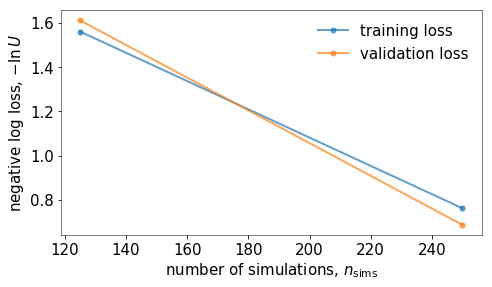

Population 2/3
Sampling proposal density...
Done.


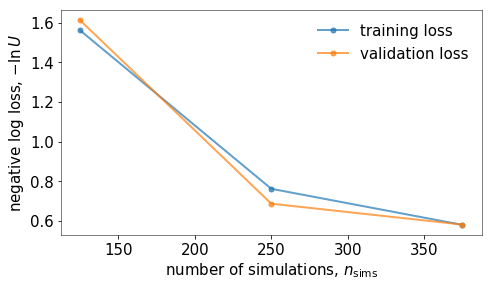

Population 3/3
Sampling proposal density...
Done.


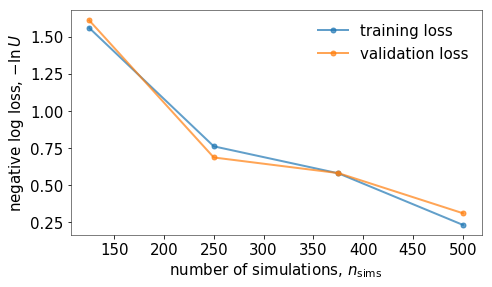

In [6]:
total_sims = 500
n_initial = 125 
n_populations = 3
n_batch = int((total_sims-n_initial)/n_populations) 
safety = int(9999/n_batch)  
n_epochs = 15 

DelfiEnsemble.sequential_training(simulator, compressor, n_initial, n_batch, n_populations,
                                  patience=max(1, int(3*n_epochs/20)),  
                                  epochs=n_epochs,
                                  safety=safety,
                                  save_intermediate_posteriors=False)

In [7]:
posterior_samples = DelfiEnsemble.emcee_sample()

Removed no burn in


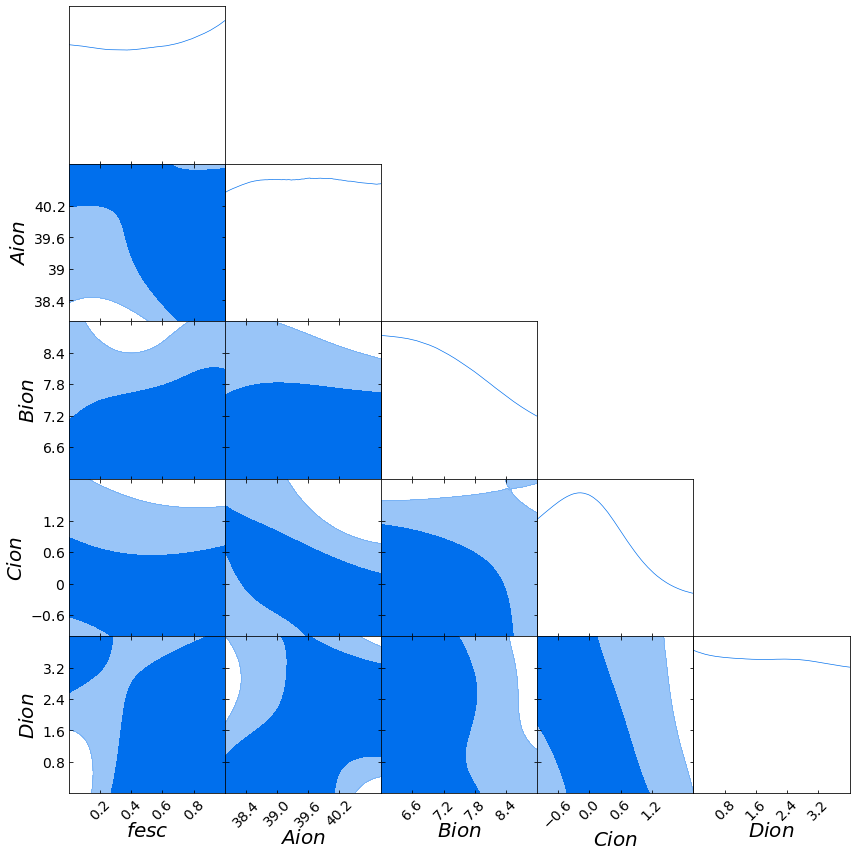

In [8]:
DelfiEnsemble.triangle_plot(samples=[posterior_samples])